# Implementing Long Short Term Memory with Keras

## Loading and Visualizing Data

In [115]:
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [116]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andreazzini/international-airline-passengers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\artur\.cache\kagglehub\datasets\andreazzini\international-airline-passengers\versions\1


In [117]:
data = pd.read_csv(path+'/international-airline-passengers.csv',skipfooter=5, engine='python') # The last 5 data was contaminated
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


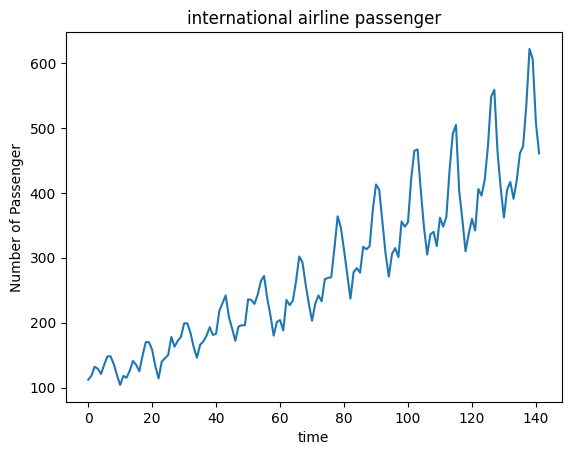

In [118]:
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("Number of Passenger")
plt.title("international airline passenger")
plt.show()

## Preprocessing Data
Reshape

Change type

Scaling

Train test split

Create dataset

In [119]:
# LSTM expects 2D or 3D input
dataset = dataset.reshape(-1,1) # outputs a column with many rows
dataset = dataset.astype("float32")
dataset.shape

(142, 1)

In [120]:
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [121]:
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 71, test size: 71 


In [122]:
time_stemp = 15 # Use the previous 10 time steps to predict the next value

dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = numpy.array(dataX)
trainY = numpy.array(dataY)  

In [123]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = numpy.array(dataX)
testY = numpy.array(dataY) 

In [124]:
trainX.shape

(55, 15)

In [125]:
# LTSM expects shape: (samples, timesteps, features)
trainX = numpy.reshape(trainX, (trainX.shape[0], time_stemp, 1))
testX = numpy.reshape(testX, (testX.shape[0], time_stemp, 1))
"Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features"

'Here: samples = number of training examples. timesteps = 10. features = 1. So each sample is treated as one time step with 10 features'

## Create LSTM Model

In [126]:
## Model's layer breakdown:
# Input layer: shape (1, 10)
# LSTM layer:
#   10 memory cells (neurons)
#   Learns temporal dependencies
# Dense layer:
#   Outputs a single value (next passenger count)

model = Sequential()
model.add(Input(shape=(time_stemp, 1))) 
model.add(LSTM(20)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028    
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026    
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025    
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025    
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024    
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027    
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 14/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 15/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

## Predictions and Visualising LSTM Model

In [127]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# Predictions are scaled in 0–1 range:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions - back to actual passenger numbers
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


trainMAE = mean_absolute_error(trainY[0], trainPredict[:,0])
testMAE = mean_absolute_error(testY[0], testPredict[:,0])
testMAPE = mean_absolute_percentage_error(testY[0], testPredict[:,0])

# calculate root mean squared error to measure average prediction error (lower is better)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print(testMAE)
print(testMAPE)
# at frist was 24 and 67

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train Score: 16.29 RMSE
Test Score: 223.93 RMSE
209.16003314103423
0.5105379431322026


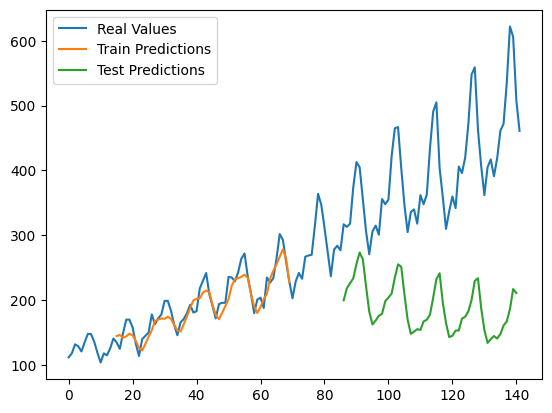

In [128]:
# shifting train
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = "Real Values")
plt.plot(trainPredictPlot, label = "Train Predictions")
plt.plot(testPredictPlot, label = "Test Predictions")
plt.legend()
plt.show()

## Assignment

 
1) Examin the original notebook. Identify why timesteps=1 is unusual and explain how to choose time_stemp properly!

    its unusual because the prediction line looks like a copy of the real data. Possibly that with only one step, the model thinks the best guess for tomorrow is just today's value.

2) Try different window sizes (e.g., 5, 15) and explain impact.
    size 5 - the model reacts too fast to small changes (last 5 months)
    size 15 - the model sees over a year of data. predictions align better vertically with real peaks (last 15 months)
    so larger windows give more context but make the model harder and sloweer to train

3) Why normalization matters for neural networks?
    increase training speed, if values are big then it becomes unstable and slow 

4) Experiment with number of neurons (5, 10, 20) and activation functions. Explain impact!
    5 - may miss complex patterns but less chance for overfitting
    20 - complex model, it can learn more details, but may be overfitting

5) Train with different batch sizes and epochs. Explain impact!
    small ammount - model havent enough time to see the patterns. Underfitting. Longer training time
    large ammount - overfitting. Model can start memorizing the noise of data. Requires more memeory but faster and smoother learning
6) If there is a different evaluation metric, try that!
    added mean absolute percentage error and mean absolute error

Advanced:

7) Predict multiple months ahead (e.g., next 3 months) instead of one.
8) Improve performance with Dropout or multiple LSTM layers.
9) Predict next 12 months and plot the forecast.

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook